In [346]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Hodgkin and Huxley

## Model

In [653]:
class HH(object):
    def __init__(self):
        pass
    
    
    def set(self, step_size=0.001):
        # Constants, v=voltage, g=conductance, c=capacitance, r=rest, l=leak, na=sodium, k=potassium
        self.c = 1.0
        self.v_r = -65.0
        self.v_l = -61.0
        self.v_na = 55.0
        self.v_k = -77.0
        self.g_l = 0.3
        self.g_na = 120.0
        self.g_k = 36.0
        
        # Membrane voltage
        self.v = -65.0
        
        # Set alpha beta variables and activation variables n, m and h
        self.update_alpha_beta()
        self.n = self.a_n/(self.a_n+self.b_n)
        self.m = self.a_m/(self.a_m+self.b_m)
        self.h = self.a_h/(self.a_h+self.b_h)
        
        self.step_size = step_size
        self.time_step = 0
        
        self.records = []
        
        
    def update_alpha_beta(self):
        v_m = self.v_r - self.v
        self.a_n = 0.01 * (v_m + 10)/(math.exp((v_m+10)/10) - 1)
        self.a_m = 0.1 * (v_m + 25)/(math.exp((v_m+25)/10) - 1)
        self.a_h = 0.07 * math.exp(v_m/20)
        self.b_n = 0.125 * math.exp(v_m/80)
        self.b_m = 4.0 * math.exp(v_m/18)
        self.b_h = 1.0 / (math.exp((v_m+30)/10) + 1)
        
        
    def step_time(self, input_current):
        self.update_alpha_beta()

        dndt = self.a_n*(1.0-self.n) - self.b_n*self.n
        dmdt = self.a_m*(1.0-self.m) - self.b_m*self.m
        dhdt = self.a_h*(1.0-self.h) - self.b_h*self.h

        # Calculate current from due to ion electrochemical gradients
        i_k = self.g_k*(self.n**4)*(self.v-self.v_k)
        i_na = self.g_na*(self.m**3)*self.h*(self.v-self.v_na)
        i_l = self.g_l*(self.v-self.v_l)

        i_ion = i_k + i_na + i_l
        dvdt = (input_current - i_ion)/self.c
        i_capacitive = self.c * dvdt

        self.v += self.step_size * dvdt
        self.n += self.step_size * dndt
        self.m += self.step_size * dmdt
        self.h += self.step_size * dhdt
        
        self.time_step += 1
        return i_capacitive, i_k, i_na, i_l
    
    
    def run(self, steps=500, input_current=20):
        self.set()
        for ii in xrange(steps):
            #i_k, i_na, i_l = 0
            if ii <= 1000:
                i_c, i_k, i_na, i_l = self.step_time(input_current=input_current)
            else:
                i_c, i_k, i_na, i_l = self.step_time(input_current=0.0)
            record = {
                'V': self.v,
                'm': self.m,
                'n': self.n,
                'h': self.h,
                'a_m': self.a_m,
                'b_m': self.b_m,
                'a_n': self.a_n,
                'b_n': self.b_n,
                'a_h': self.a_h,
                'b_h': self.b_h,
                'I_Cap': i_c,
                'I_K': i_k,
                'I_Na': i_na,
                'I_Leak': i_l,
                'G_K': self.g_k * (self.n**4),
                'G_Na': self.g_na * (self.m**3) * self.h,
                'time_step': self.time_step
            }
            self.records.append(record)
            
            
    def plot_vs_v(self, values):
        df = pd.DataFrame(self.records)
        for value in values:
            plt.plot(df['v'], df[value])
            #plt.plot(df[value])
            plt.ylim(df[value].min(), df[value].max())
            plt.xlim(-110, 50)
            plt.ylabel(value)
            plt.xlabel('mV')
        plt.show()
            
            
    def plot_vs_time(self, values, y_title):
        df = pd.DataFrame(self.records)
        fig, ax = plt.subplots()
        for value in values:
            ax.plot(df['time_step']*self.step_size, df[value], label=value)
        legend = ax.legend() # call this to set legend
        plt.ylabel(y_title)
        plt.xlabel('t (ms)')
        plt.show()
            

## Plots

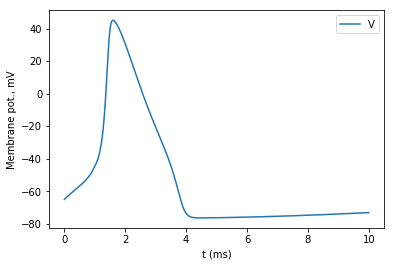

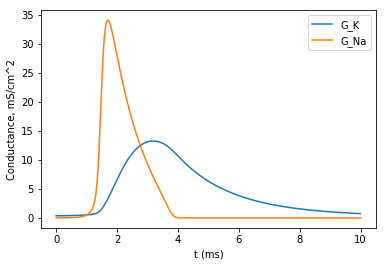

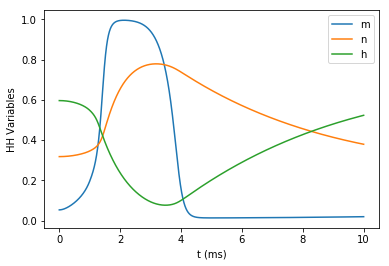

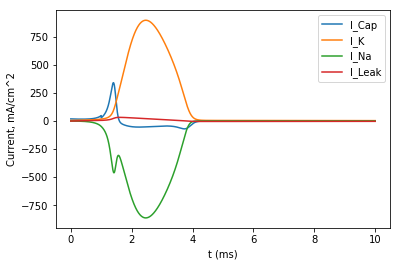

In [656]:
model = HH()
model.run(steps=10000)
#model.plot_vs_v(['g_k'])
model.plot_vs_time(['V'], y_title='Membrane pot., mV')
model.plot_vs_time(['G_K', 'G_Na'], y_title='Conductance, mS/cm^2')
model.plot_vs_time(['m', 'n', 'h'], y_title='HH Variables')
model.plot_vs_time(['I_Cap', 'I_K', 'I_Na', 'I_Leak'], y_title='Current, mA/cm^2')

## Analysis

### (TODO)

# Integrate and Fire (IAF)

## Model

In [321]:
class IAF(object):
    def __init__(self):
        pass
    
    
    def set(self):
        # Constants, r=resistance, c=capacitance, v_thr=volage threshold, v_spk=peak of AP
        self.r = 10
        self.c = 1.0
        self.v_thr = 5.0
        self.v_spk = 70.0
    
        self.v = -0.0
        
        self.input_current = 0.0
        self.time_step = 0
        
        self.records = []
        
    
    def step_time(self, step_size=1.0, sinusoidal_current=False, hertz=1.0):
        if sinusoidal_current is False:
            if self.time_step >= 10 and self.time_step <= 60:
                self.input_current = 1.0
            else:
                self.input_current = 0.0
        else:
            frequency = 2 * math.pi * hertz
            self.input_current = math.sin(frequency*(self.time_step*1.0/1000))
            
        old_v = self.v
        if self.v < self.v_thr:
            dvdt = (self.input_current - self.v/self.r)/self.c
            self.v += step_size * dvdt
        elif self.v == self.v_spk:
            self.v = 0.0
        elif self.v >= self.v_thr:
            self.v = self.v_spk
        
        self.time_step += 1
        return
        
        
    def run(self, steps=100, sinusoidal_current=False, hertz=1.0):
        self.set()
        for ii in xrange(steps):
            self.step_time(sinusoidal_current=sinusoidal_current, hertz=hertz)
            record = {
                'v': self.v,
                't': self.time_step,
                'input_current': self.input_current
            }
            self.records.append(record)
        
        
    def plot_v(self):
        df = pd.DataFrame(self.records)
        plt.plot(df['v'])
        plt.ylabel('mV')
        plt.xlabel('t (ms)')
        plt.show()

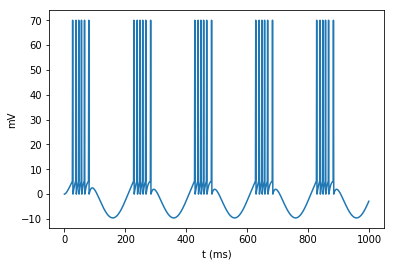

In [341]:
model = IAF()
model.run(steps=1000, sinusoidal_current=True, hertz=5.0)
model.plot_v()

# Linear-Nonlinear Neuron

## Model

In [609]:
class LNNeuron(object):
    def __init__(self):
        pass
    
    
    def load_data(self, spikes_file, stimulus_file, num_trials=5, trial_size=20000):
        self.all_raw_spikes = np.loadtxt(spikes_file, dtype=float) * 1000 # convert from s to ms
        self.raw_stimulus = np.loadtxt(stimulus_file, dtype=float) 
        
        # Split total raw spikes data into their respective trials
        self.raw_spikes = {}
        trial = 1 # tracks the trial we're collecting
        trial_end = trial_size # this will track the absolute end time of whatever trial we're collecting
        trial_spikes = [] # holds the raw spikes of the trial we're collecting
        for ii in xrange(len(self.all_raw_spikes)):
            raw_spike = self.all_raw_spikes[ii]
            
            # Attribute spike to trial
            if raw_spike < trial_end:
                raw_spike -= (trial - 1) * trial_size # set all trials to be from 0ms-trial_size
                trial_spikes.append(raw_spike)
                
            # Iterate trial
            if raw_spike >= trial_end:
                self.raw_spikes['trial_{}'.format(trial)] = np.array(trial_spikes)
                trial_spikes = []
                trial_end += trial_size
                trial += 1
                
            # Termination cases
            if ii == len(self.all_raw_spikes) - 1:
                self.raw_spikes['trial_{}'.format(trial)] = np.array(trial_spikes)
                break
            elif trial > num_trials:
                break
        
#         for k, v in self.raw_spikes.iteritems():
#             print k, v
#             print '\n'
#         #print self.all_raw_spikes[17]
#         #print (np.floor(self.all_raw_spikes/100)*100)[17]
#         print self.raw_stimulus
        
    
    def process_data(self, trial_time=20000, bin_size=100):
        self.spikes = {}
        self.stimulus = []
        
        bins = []
        bin_end = 0
        while bin_end <= trial_time:
            bins.append(bin_end)
            bin_end += bin_size
        
        for trial, raw_spikes in self.raw_spikes.iteritems():
            bin_data = self._digitize(raw_spikes, bins)
            
            self.spikes[trial] = bin_data
           
        self.stimulus = self._digitize(self.raw_stimulus, bins)
        
#         for k, v in self.spikes.iteritems():
#             print len(v)
#             print k, v
#             print '\n'
#         print len(self.stimulus)
#         print self.stimulus
#         print self.raw_stimulus
        
        
    def train(self, spike_trials, stimulus, stimulus_bins=20):
        # Stimulus
        s = np.matrix(self.rolling_window(stimulus, stimulus_bins))
        
        # Response
        r = np.zeros((len(spike_trials), (len(s))))
        print r.shape
        print r.shape[0], r.shape[1]
        for ii in xrange(r.shape[0]):
            spikes = spike_trials[ii]
            for jj in xrange(r.shape[1]):
                 r[ii][jj] = spikes[jj+stimulus_bins-1]    
#         for ii in xrange(len(s)):
#             r[ii] = spikes[ii+stimulus_bins-1]
        r = np.matrix(r).transpose()
        
        # Linear regression, L2 penalty
        # Find w that minimizes (r - sw)^2 where sw is predicted response at end of stimulus
        # Closed form solution (TODO: use gradient descent for large dataset):
        sT = s.transpose()
        sTs = sT * s
        sTr = sT * r
        w = np.linalg.inv(sTs) * sTr
        
        print 's', s.shape
        print 'r', r.shape
        print 'sT', sT.shape
        print 'sTs', sTs.shape
        print 'sTr', sTr.shape
        print '(sTs)^-1', np.linalg.inv(sTs).shape
        print 'w', w.shape
        
        return s, w
    
    
    def run(self, s, w):
        r = []
        for stim in s:
            r.append((stim * w).item(0)) # get scalar value since output is 1x1 matrix
        return r
        
    
    def _digitize(self, data, bins):
        bin_data = np.zeros(len(bins)-1)
        bin_idx = 0
        x_idx = 0
        while bin_idx <= len(bins) + 2:
            x = data[x_idx]
            if bin_idx == len(bins) - 2:
                if x >= bins[bin_idx]:
                    bin_data[bin_idx] = 1
                    x_idx += 1 
            elif x >= bins[bin_idx] and x < bins[bin_idx+1]:
                bin_data[bin_idx] = 1
                x_idx += 1
            elif x >= bins[bin_idx+1]:
                bin_idx += 1

            if x_idx > len(data) - 1:
                break
        
        return bin_data
    
    
    def rolling_window(self, a, window):
        """
        From https://stackoverflow.com/questions/6811183/rolling-window-for-1d-arrays-in-numpy
        @param a: data to roll window along
        @param windows: the size of the window
        """
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    

In [617]:
model = LNNeuron()
model.load_data(spikes_file='spikes.txt', stimulus_file='stimulus.txt')
model.process_data()
train_spikes = [model.spikes['trial_1'], model.spikes['trial_2'], model.spikes['trial_3'], model.spikes['trial_4']]
s, w = model.train(spike_trials=train_spikes, stimulus=model.stimulus, stimulus_bins=20)

w_avg = np.mean(w, axis=1)
r = model.run(s, w_avg)

(4, 181)
4 181
s (181, 20)
r (181, 4)
sT (20, 181)
sTs (20, 20)
sTr (20, 4)
(sTs)^-1 (20, 20)
w (20, 4)


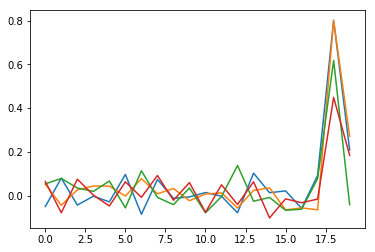

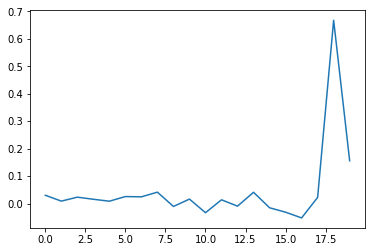

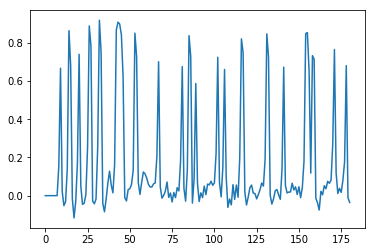

In [618]:
plt.plot(w)
plt.show()
plt.plot(np.mean(w, axis=1))
plt.show()
plt.plot(r)
plt.show()

In [612]:
print w

[[-0.04966044  0.05237965  0.05354891  0.06489722]
 [ 0.07974638 -0.04404972  0.0784871  -0.07845097]
 [-0.0431932   0.02645454  0.03491714  0.07513886]
 [-0.00261595  0.04388402  0.01925567  0.00225476]
 [-0.02838422  0.04344295  0.06682938 -0.04728586]
 [ 0.09683331 -0.0017658  -0.05588065  0.06303551]
 [-0.08518774  0.07778112  0.11361428 -0.00783279]
 [ 0.07377035  0.00853773 -0.00796994  0.09202135]
 [-0.01238806  0.03264702 -0.04112629 -0.02111616]
 [-0.00588995 -0.02322644  0.03479258  0.05964743]
 [ 0.01424272  0.00733225 -0.0781575  -0.07612441]
 [-0.00275195  0.01267311 -0.00424987  0.04947861]
 [-0.07846786 -0.05643803  0.13784302 -0.04026927]
 [ 0.10283742  0.02410975 -0.02556676  0.06324583]
 [ 0.01345302  0.03577242 -0.00821843 -0.10183567]
 [ 0.02158046 -0.06539389 -0.06677995 -0.01479409]
 [-0.05790005 -0.05604338 -0.06231258 -0.03237767]
 [ 0.09263248 -0.06476637  0.07726092 -0.01581563]
 [ 0.80139291  0.8005673   0.61783661  0.4487977 ]
 [ 0.2084186   0.27181205 -0.04